##### 1) Sélectionner 1000 point de départs aléatoirement

##### 2) Sélectionner 1000 Points d'arrivée aléatoirement différents des points de départ

- pour chaque paire départ-arrivée, calculer l'itinéraire le plus court
- A ce stade, tu as une matrice de 1000 * 1000

##### 3) sélectionner aléatoirement une distance entre 200m et 4000m (i.e. un entier entre 200 et 4000)

##### 4) sélectionner un des départ de la matrice et prendre l'arrivée qui correspond à la distance la plus proche de la distance sélectionner aléatoirement

##### 5) recommencer 3 et 4 jusqu'à ce que tous les départs soient associés à une arrivée et 1 seul

##### 6) Enregistrer le résultat dans un fichier

# Changer de méthode calcul de la matrice trop de temps de calcul 

##### 1) Sélectionner 2000 points de départ aléatoirement
##### 2) Sélectionner 2000 points d'arrivée aléatoirement différents des points de départ
##### 3) Pour chaque paire départ-arrivée, calculer l'itinéraire le plus court
##### 4) Sélectionner aléatoirement une distance entre 600m et 4000m
##### 5) Associer chaque départ à une arrivée ayant une distance la plus proche de la distance sélectionnée
##### 6) Enregistrer le résultat dans un fichier

In [2]:
import sys
sys.path.append("../")

sys.path.append("../../../../script_python")
from data_utils import *
from function_utils import *

sys.path.append("../../../")
from global_variable import *
import geopandas as gpd
import pandas as pd

# Charger le fichier GPKG
gpkg_path = globpath("./score_calculation_it/output_data/network/graph/final_network_bruit.gpkg")
edges = gpd.read_file(gpkg_path, layer="edges")

# Ajouter une colonne total_score_bruit en initialisant à la somme des scores existants
edges["total_score_bruit"] = edges[["bruit_score", "score_distance_bruit"]].sum(axis=1, skipna=True)

# Vérifier le nombre de NaN avant correction
print("Nombre de NaN avant correction :")
print(edges[["bruit_score", "score_distance_bruit", "total_score_bruit"]].isna().sum())

# Première passe : Interpolation par moyenne glissante
edges["bruit_score"] = edges["bruit_score"].fillna(edges["bruit_score"].rolling(5, min_periods=1).mean())
edges["score_distance_bruit"] = edges["score_distance_bruit"].fillna(edges["score_distance_bruit"].rolling(5, min_periods=1).mean())
edges["total_score_bruit"] = edges["total_score_bruit"].fillna(edges["total_score_bruit"].rolling(5, min_periods=1).mean())

# Deuxième passe : Utilisation des segments voisins
for index, row in edges.iterrows():
    if pd.isna(row["bruit_score"]):
        voisins = edges[(edges["u"] == row["v"]) | (edges["v"] == row["u"])]
        mean_voisin = voisins["bruit_score"].mean(skipna=True)
        edges.at[index, "bruit_score"] = mean_voisin

    if pd.isna(row["score_distance_bruit"]):
        voisins = edges[(edges["u"] == row["v"]) | (edges["v"] == row["u"])]
        mean_voisin = voisins["score_distance_bruit"].mean(skipna=True)
        edges.at[index, "score_distance_bruit"] = mean_voisin
    
    if pd.isna(row["total_score_bruit"]):
        voisins = edges[(edges["u"] == row["v"]) | (edges["v"] == row["u"])]
        mean_voisin = voisins["total_score_bruit"].mean(skipna=True)
        edges.at[index, "total_score_bruit"] = mean_voisin

# Troisième passe : Remplacement final avec la médiane globale
edges["bruit_score"].fillna(edges["bruit_score"].median(), inplace=True)
edges["score_distance_bruit"].fillna(edges["score_distance_bruit"].median(), inplace=True)
edges["total_score_bruit"].fillna(edges["total_score_bruit"].median(), inplace=True)

# Vérifier le nombre de NaN après correction
print("\nNombre de NaN après correction :")
print(edges[["bruit_score", "score_distance_bruit", "total_score_bruit"]].isna().sum())

# Sauvegarder le fichier nettoyé en écrasant l'original
edges.to_file(gpkg_path, layer="edges", driver="GPKG")
print(f"\nFichier nettoyé enregistré sous '{gpkg_path}'.")


ModuleNotFoundError: No module named 'data_utils'

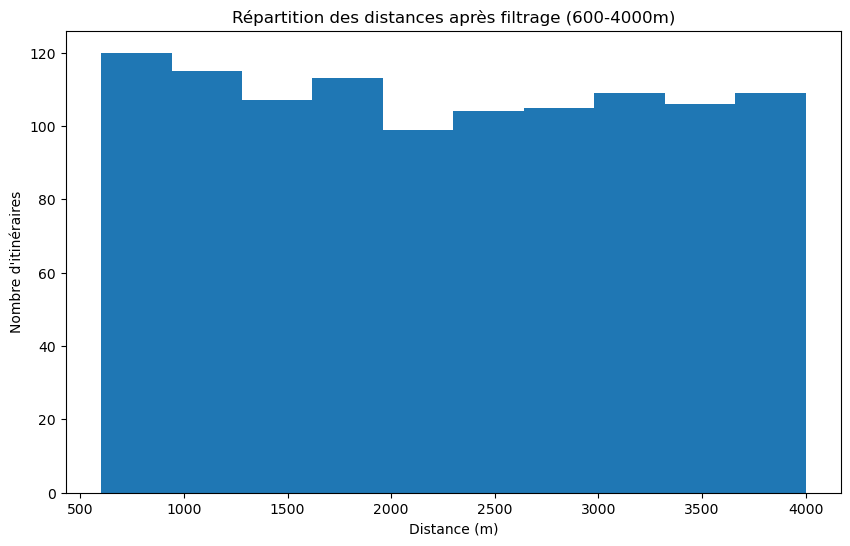

Calcul terminé : 1087 itinéraires enregistrés dans 'itinéraire_court.csv' !


In [ ]:
import geopandas as gpd
import networkx as nx
import random
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

# Charger les données
gpkg_path = globpath("./score_calculation_it/output_data/network/graph/final_network_bruit.gpkg")
edges = gpd.read_file(gpkg_path, layer="edges")
nodes = gpd.read_file(gpkg_path, layer="nodes")

# Construire le graphe routier
G = nx.DiGraph()
for _, row in edges.iterrows():
    G.add_edge(row['u'], row['v'], length=row['length'])
    if not row['oneway']:
        G.add_edge(row['v'], row['u'], length=row['length'])

# Sélectionner 2000 départs et 2000 arrivées aléatoires
num_points = 2000  
depart_nodes = random.sample(list(G.nodes), num_points)
arrival_nodes = random.sample([n for n in G.nodes if n not in depart_nodes], num_points)

# Fonction pour calculer les plus courts chemins à partir d'un départ
def compute_shortest_paths(depart):
    distances = nx.single_source_dijkstra_path_length(G, depart, weight='length')
    # Exclure les distances infinies et filtrer entre 50 et 6000m
    valid_distances = {arr: dist for arr, dist in distances.items() if 50 <= dist <= 6000}
    return depart, valid_distances

# Calcul des distances en parallèle
distance_matrix = {}
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(compute_shortest_paths, depart_nodes))

# Récupération des résultats
for dep, dist in results:
    distance_matrix[dep] = dist

# Générer une liste **équilibrée** de distances cibles entre 50 et 6000m
target_distances = np.linspace(50, 6000, num=num_points)  
random.shuffle(target_distances)  # Mélanger pour éviter un ordre biaisé

# Associer chaque départ à une arrivée unique avec la distance la plus proche
selected_routes = []
used_arrivals = set()

for i, dep in enumerate(depart_nodes):
    if not distance_matrix[dep]:  # Si aucun itinéraire valide, on passe ce départ
        continue
    
    target_distance = target_distances[i]  # Sélectionner une distance plus homogène
    
    # Filtrer les arrivées valides (non utilisées et avec distance correcte)
    possible_arrivals = {arr: dist for arr, dist in distance_matrix[dep].items() if arr not in used_arrivals}
    
    if possible_arrivals:
        best_arr = min(possible_arrivals, key=lambda arr: abs(possible_arrivals[arr] - target_distance))
        selected_routes.append((dep, best_arr, possible_arrivals[best_arr]))
        used_arrivals.add(best_arr)

# Convertir en DataFrame
itineraire_df = pd.DataFrame(selected_routes, columns=['start_node', 'end_node', 'distance_court'])

# Filtrer pour ne garder que les itinéraires entre 600 et 4000m
itineraire_df = itineraire_df[(itineraire_df['distance_court'] >= 600) & (itineraire_df['distance_court'] <= 4000)]

# Sauvegarder les résultats filtrés
itineraire_df.to_csv("itinéraire_court.csv", index=False)

# Visualisation des distances pour vérifier homogénéité après filtrage
plt.figure(figsize=(10, 6))
plt.hist(itineraire_df['distance_court'])  
plt.xlabel("Distance (m)")
plt.ylabel("Nombre d'itinéraires")
plt.title("Répartition des distances après filtrage (600-4000m)")
plt.show()

print(f"Calcul terminé : {len(itineraire_df)} itinéraires enregistrés dans 'itinéraire_court.csv' !") 

In [2]:
itineraire_df

,start_node,end_node,distance_court
0,3380751025,5657136849,2742.877
1,11356942377,171760149,1910.433
3,2225197158,4463347218,3511.353
4,7603662257,8913559675,875.318
6,6915264516,373344984,1826.830
...,...,...,...
1954,1357967486,591898696,3091.884
1955,12061323808,252413479,1594.809
1956,976140519,7356888324,1362.956
1960,11197666281,2838044698,3505.793
